In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import linear_model as lm 
import numpy as np

In [2]:
df = pd.read_excel('cleaned_countries__cities_dataset.xlsx')

In [3]:
mask = (df['population'] == 0) | (df['name'] == "World")  | ((df['population'] != 0) & (df['area'] == 0))
cleaned_df = df[~mask].copy()

In [4]:
cleaned_df.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [5]:
features = ["population", "area", "birth_rate", "death_rate", "migration_rate"]
target = "population_growth"

missing_values = cleaned_df[features + [target]].isnull().sum()
summary_stats = cleaned_df[features + [target]].describe()

missing_values, summary_stats

(population           0
 area                 0
 birth_rate           0
 death_rate           0
 migration_rate       0
 population_growth    0
 dtype: int64,
          population          area  birth_rate  death_rate  migration_rate  \
 count  2.380000e+02  2.380000e+02  238.000000  238.000000      238.000000   
 mean   3.265142e+07  5.912190e+05   18.438277    7.459874        3.217521   
 std    1.290036e+08  1.773073e+06   10.117422    3.262732        4.346165   
 min    4.800000e+01  2.000000e+00    0.000000    0.000000        0.000000   
 25%    3.357808e+05  2.322750e+03   11.062500    5.340000        0.220000   
 50%    5.311480e+06  7.358000e+04   16.080000    7.320000        1.650000   
 75%    1.873804e+07  4.304258e+05   24.145000    9.387500        4.527500   
 max    1.370000e+09  1.709824e+07   45.450000   14.890000       22.390000   
 
        population_growth  
 count         238.000000  
 mean            1.186345  
 std             0.907618  
 min             0.000000

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [7]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
X = cleaned_df[features]
y = cleaned_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((190, 5), (48, 5), (190,), (48,))

Evaluate model performance

In [9]:
y_pred = pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")

R²: 0.733, MAE: 0.307, RMSE: 0.437


Comparing train and test performance (checkign for overfitting)

In [10]:
train_score = pipe.score(X_train, y_train)  # R² on training data
test_score = pipe.score(X_test, y_test)     # R² on test data

print(f"Train R²: {train_score:.3f}, Test R²: {test_score:.3f}")

Train R²: 0.664, Test R²: 0.733


Interpretting model

In [11]:
# Extract the LinearRegression step from the pipeline
lr_model = pipe.named_steps['linearregression']

# Coefficients (for scaled features!)
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Map coefficients to feature names
feature_names = X_train.columns.tolist()
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (scaled)': coefficients
})

print(coeff_df)
print(f"Intercept: {intercept:.3f}")

          Feature  Coefficient (scaled)
0      population             -0.018019
1            area              0.005580
2      birth_rate              0.793160
3      death_rate             -0.202456
4  migration_rate              0.018650
Intercept: 1.194


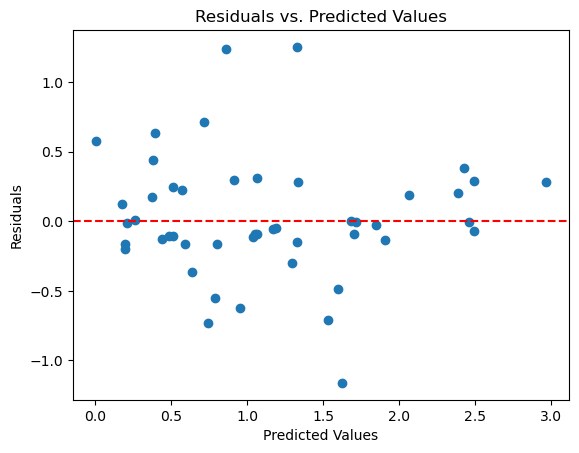

In [12]:
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

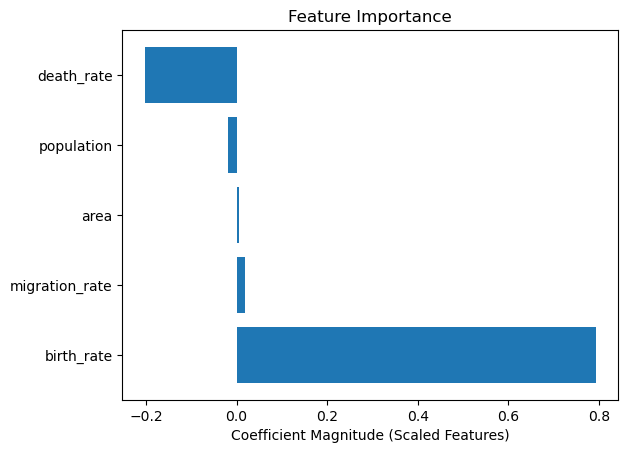

In [13]:
coeff_df.sort_values(by='Coefficient (scaled)', ascending=False, inplace=True)
plt.barh(coeff_df['Feature'], coeff_df['Coefficient (scaled)'])
plt.xlabel("Coefficient Magnitude (Scaled Features)")
plt.title("Feature Importance")
plt.show()

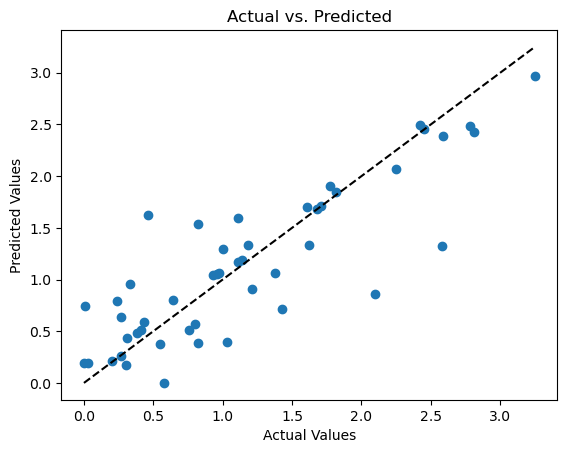

In [14]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()